In [1]:
import os
# os.system("export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/")

In [2]:
pip install icecream

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import os
import sys
import os
from icecream import ic 
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tqdm.notebook import tqdm

In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# only needed for colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
os.chdir('/content/drive/MyDrive/SYMBA/')

In [7]:
os.listdir()

['2022-07-20-RNNAttention',
 '2022-07-20-FirstTransformer',
 'data.nosync_old',
 'data.nosync',
 '2022-08-22-Transformer',
 'models',
 '2022-08-24-Transformer-NewData',
 'QED']

In [8]:
amplitudes_files = [
    "data.nosync/train/QED_amplitudes_TreeLevel_1to2_train.txt",
    "data.nosync/train/QED_amplitudes_TreeLevel_2to1_train.txt",
    "data.nosync/train/QED_amplitudes_TreeLevel_2to2_train.txt",
    "data.nosync/train/QED_amplitudes_TreeLevel_2to3_train.txt",
    "data.nosync/train/QED_amplitudes_TreeLevel_3to2_train.txt",
]
sqamplitudes_files = [
    "data.nosync/train/QED_sqamplitudes_TreeLevel_1to2_simplified_shortened_hybridprefix_train.txt",
    "data.nosync/train/QED_sqamplitudes_TreeLevel_2to1_simplified_shortened_hybridprefix_train.txt",
    "data.nosync/train/QED_sqamplitudes_TreeLevel_2to2_simplified_shortened_hybridprefix_train.txt",
    "data.nosync/train/QED_sqamplitudes_TreeLevel_2to3_simplified_shortened_hybridprefix_train.txt",
    "data.nosync/train/QED_sqamplitudes_TreeLevel_3to2_simplified_shortened_hybridprefix_train.txt",
]

In [9]:
X_train = []
for file in amplitudes_files:
    with open(file, 'r') as f:
        for line in f.readlines() :
            line = line.split(",")
            line[-1] = line[-1].replace("\n", "")
            X_train.append(line)

y_train = []
for file in sqamplitudes_files:
    with open(file, 'r') as f:
        for line in f.readlines() :
            line = line.split(",")
            line[-1] = line[-1].replace("\n", "")
            # line = ["[START]"] + line + ["[END]"]
            y_train.append(line)

In [10]:
assert len(X_train) == len(y_train)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.02, random_state=42)

In [12]:
ic(len(X_train))
ic(len(X_val))

ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?


4770

# Creating the Dataset

In [13]:
vocab_size = 500
sequence_length = 350
batch_size = 8

In [14]:
X_train_idx_okay = np.where([len(x) < sequence_length for x in X_train])[0]
y_train_idx_okay = np.where([len(y) < sequence_length for y in y_train])[0]
train_idx_okay = np.intersect1d(X_train_idx_okay, y_train_idx_okay) 
X_train_short = [X_train[i] for i in train_idx_okay]
y_train_short = [y_train[i] for i in train_idx_okay]
X_train_text = [" ".join(x) for x in X_train_short]
y_train_text = [" ".join(yy) for yy in y_train_short]

print("X train: {}% okay".format(len(X_train_idx_okay)/len(X_train)))
print("y train: {}% okay".format(len(y_train_idx_okay)/len(X_train)))


X_val_idx_okay = np.where([len(x) < sequence_length for x in X_val])[0]
y_val_idx_okay = np.where([len(y) < sequence_length for y in y_val])[0]
val_idx_okay = np.intersect1d(X_val_idx_okay, y_val_idx_okay) 
X_val_short = [X_val[i] for i in val_idx_okay]
y_val_short = [y_val[i] for i in val_idx_okay]
X_val_text = [" ".join(x) for x in X_val_short]
y_val_text = [" ".join(yy) for yy in y_val_short]

print("X val: {}% okay".format(len(X_val_idx_okay)/len(X_val)))
print("y val: {}% okay".format(len(y_val_idx_okay)/len(X_val)))

X train: 0.9461537474167918% okay
y train: 0.8247140821749008% okay
X val: 0.9410901467505242% okay
y val: 0.8169811320754717% okay


In [15]:
def custom_standardization(input_string):
    return input_string

X_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=None,
)

y_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length+1,
    standardize=None,
)

In [16]:
X_vectorization.adapt(X_train_text)
y_vectorization.adapt(y_train_text)

In [17]:
def format_dataset(X, y):
    X_vec = X_vectorization(X)
    y_vec = y_vectorization(y)
    return (
        {
            "encoder_inputs": X_vec,
            "decoder_inputs": y_vec[:, :-1],
        },
        y_vec[:, 1:],
    )


def make_dataset(X_text, y_text):
    dataset = tf.data.Dataset.from_tensor_slices((X_text, y_text))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(X_train_text, y_train_text)
val_ds = make_dataset(X_val_text, y_val_text)
# test_ds = make_dataset(X_test_text, y_test_text)

# Model

In [18]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [19]:
embed_dim = 256  # 512
latent_dim = 2048  # 16384
num_heads = 8

# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
encoder_inputs = keras.Input(shape=(None,), dtype="int32", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int32", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   217600      ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

In [20]:
def create_lr_func(min_lr, max_epochs, max_lr_factor=4.0):
    initial_lr = min_lr 
    max_lr = min_lr*max_lr_factor 
    def learning_rate_cyclic(epoch):
        if epoch <= (max_epochs / 2):
            lr = initial_lr + (max_lr-initial_lr) * epoch/(max_epochs/2)
            return lr
        if (epoch > (max_epochs / 2)) & (epoch < max_epochs):
            lr = max_lr - (max_lr-initial_lr) * (epoch-max_epochs/2)/(max_epochs/2)
            return lr
        else:
            lr = initial_lr*np.exp(-(epoch-max_epochs)/10)
            return lr
    return learning_rate_cyclic

Text(0, 0.5, 'learning rate')

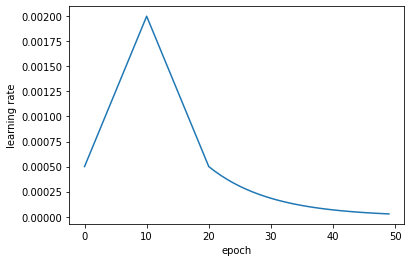

In [21]:
xrange = range(0,50)
yrange = [create_lr_func(0.0005, 20, 4.0)(x) for x in xrange]
plt.plot(xrange, yrange)
plt.xlabel("epoch")
plt.ylabel("learning rate")

In [ ]:
epochs = 50  # This should be at least 30 for convergence
lr_schedule = tf.keras.callbacks.LearningRateScheduler(create_lr_func(0.0005, 20, 4.0))
checkpoint = keras.callbacks.ModelCheckpoint(
    "models/2022-10-04-Transformer_3to2", save_best_only=True, monitor="val_loss", save_weights_only=True
)

callbacks = [lr_schedule, checkpoint]

transformer.summary()
transformer.compile(
    "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds,
                          callbacks = callbacks)


Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   217600      ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

In [ ]:
transformer.save_weights("models/2022-10-04-Transformer_3to2_50epochs")

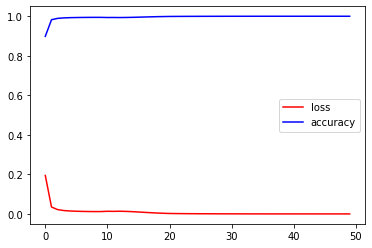

In [ ]:
plt.plot(history.history['loss'], c="r", label="loss")
plt.plot(history.history['accuracy'], c='b', label="accuracy")
plt.legend()
plt.show()

In [22]:
transformer.load_weights("models/2022-10-04-Transformer_3to2_50epochs")

In [28]:
y_vocab = y_vectorization.get_vocabulary()
y_index_lookup = dict(zip(range(len(y_vocab)), y_vocab))
max_decoded_sentence_length = 350


def decode_sequence(input_sentence):
    tokenized_input_sentence = X_vectorization([input_sentence])
    decoded_sentence = "[start]"
    probas = []
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = y_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        # proba = proba*predictions[0,i,sampled_token_index]
        probas = probas + predictions[0,i,sampled_token_index]
        sampled_token = y_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[END]":
            break
    return decoded_sentence, probas.numpy()

In [29]:
decode_sequence(X_val_text[0])

('[start] mul( mul s- 16 pow 81 s- 1 pow e 6 pow add( reg_prop s_33 mul 2 s_23 ) s- 2 pow add( m2mu reg_prop s_11 mul s- 2 s_14 ) s- 2 add( mul m2d add( mul s- 2 m2muxs_25 mul s- 2 m2muxs_35 mul 4 m2muxs_23 mul 4 m2muxs_33 mul( s- 2 s_14 s_23 ) mul( s- 2 s_14 s_33 ) mul( 2 s_12 s_45 ) mul( 2 s_13 s_45 ) mul( 2 s_15 s_24 ) mul( 2 s_15 s_34 ) ) mul m4d add mul s- 2 s_14 mul 4 m2mu mul( s- 1 m2muxs_25 s_33 ) mul( 2 m2muxs_23 s_35 ) mul( s_12 s_33 s_45 ) mul( s_15 s_24 s_33 ) mul( s- 2 s_13 s_23 s_45 ) mul( s- 2 s_15 s_23 s_34 ) ) ) [END]',
 array([], dtype=float32))

In [39]:
train_true_file = "./predictions/2022-10-07-train_true.txt"
train_pred_file = "./predictions/2022-10-07-train_pred.txt"
train_pred_probas_file =  "./predictions/2022-10-07-train_pred_probas.txt"
val_true_file = "./predictions/2022-10-07-val_true.txt"
val_pred_file = "./predictions/2022-10-07-val_pred.txt"
val_pred_probas_file =  "./predictions/2022-10-07-val_pred_probas.txt"

In [40]:
os.listdir()

['2022-07-20-RNNAttention',
 '2022-07-20-FirstTransformer',
 'data.nosync_old',
 'data.nosync',
 '2022-08-22-Transformer',
 'models',
 '2022-08-24-Transformer-NewData',
 'QED',
 'predictions']

In [41]:
y_val_pred = [decode_sequence(x) for x in tqdm(X_val_text[0:500])]
y_val_probas = [y[1] for y in y_val_pred]
y_val_pred = [y[0] for y in y_val_pred]

with open(val_pred_file, "w") as f:
    for line in y_val_pred:
        f.write(line)
        f.write("\n")

with open(val_true_file, "w") as f:
    for line in y_val_text:
        f.write(line)
        f.write("\n")

with open(val_pred_probas_file, "w") as f:
    for line in y_val_probas:
        f.write(str(line))
        f.write("\n")

In [43]:
def token_accuracy(y_true, y_pred, verbose=0, pred_has_start_end_tokens=True):
    """
    compare two arrays and check how many entries are the same at the same position
    """
    true = y_true.split(" ")
    pred = y_pred.split(" ")
    if pred_has_start_end_tokens:
        pred = pred[1:-1]
    max_ind = np.min([len(true), len(pred)])
    correct_ctr = 0
    # ignore [start] and [end]
    max_correct = len(pred)
    for i in range(max_ind):
        if verbose: ic([true[i], pred[i]])
        if true[i] == pred[i]:
            correct_ctr += 1
    return correct_ctr / max_correct

In [45]:
val_accs = [token_accuracy(y_val_text[i], y_val_pred[i], pred_has_start_end_tokens=False) for i in range(len(y_val_pred))]
print("val:", np.mean(val_accs)) 

val: 0.4816969419028278


In [ ]:
y_train_pred = [decode_sequence(x) for x in tqdm(X_train_text[0:100])]
y_train_probas = [y[1] for y in y_train_pred]
y_train_pred = [y[0] for y in y_train_pred]

with open(train_true_file, "w") as f:
    for line in y_train_text:
        f.write(line)
        f.write("\n")

with open(train_pred_file, "w") as f:
    for line in y_train_pred:
        f.write(line)
        f.write("\n")

with open(train_pred_probas_file, "w") as f:
    for line in y_train_probas:
        f.write(str(line))
        f.write("\n")